# Section I - Business Understanding

**Kaggle has provided the following description and business context with a dataset for L&T Vehicle Loan Defaul Prediction:**

(The description is quoted below and can be found at this link along with the dataset: https://www.kaggle.com/mamtadhaker/lt-vehicle-loan-default-prediction?select=data_dictionary.csv)

"*Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. 
The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default.*

*A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided in the datasets:*

*Loanee Information (Demographic data like age, Identity proof etc.)
Loan Information (Disbursal details, loan to value ratio etc.)
Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)
Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates."*

## Objective

**My first objective here is to derive insights on attributes related to vehicle loan defaulting and build an initial predictive model & pipeline.**

**Early questions of interest to investigate:**

* What are the most influential attributes associated with vehicle loan defaults?
* If someone has been shopping around for loans, what is the relationship between number of loan inquiries and potential to default the loan?
* How does credit history age affect risk to default?

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Section II - Data Understanding

## Access

In [2]:
data_dictionary = pd.read_csv('data_dictionary.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Explore

Print data dictionary

In [3]:
data_dictionary[['Variable Name', 'Description', 'Unnamed: 2']]

,Variable Name,Description,Unnamed: 2
0,UniqueID,Identifier for customers,NaN
1,loan_default,Payment default in the first EMI on due date,NaN
2,disbursed_amount,Amount of Loan disbursed,NaN
3,asset_cost,Cost of the Asset,NaN
4,ltv,Loan to Value of the asset,NaN
5,branch_id,Branch where the loan was disbursed,NaN
6,supplier_id,Vehicle Dealer where the loan was disbursed,NaN
7,manufacturer_id,"Vehicle manufacturer(Hero, Honda, TVS etc.)",NaN
8,Current_pincode,Current pincode of the customer,NaN
9,Date.of.Birth,Date of birth of the customer,NaN


**View distribution of classes in target**

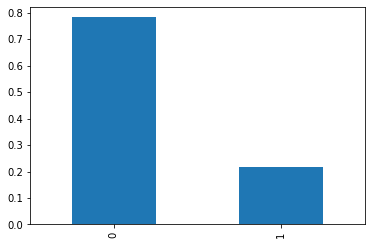

In [4]:
train['loan_default'].value_counts(normalize=True).plot(kind = 'bar');

Visualizing/Checking out some of the main financial fields

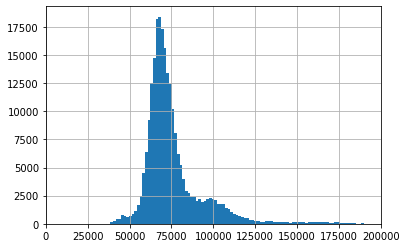

In [5]:
#vehicle value

ax = train['asset_cost'].hist(bins = 1000)
ax.set_xlim(0, 200000);

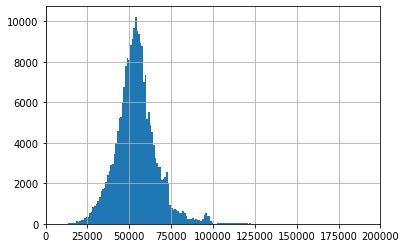

In [6]:
#loan amount

ax = train['disbursed_amount'].hist(bins = 1000)
ax.set_xlim(0, 200000);

In [7]:
train[['asset_cost','disbursed_amount']].describe()

,asset_cost,disbursed_amount
count,2.331540e+05,233154.000000
mean,7.586507e+04,54356.993528
std,1.894478e+04,12971.314171
min,3.700000e+04,13320.000000
25%,6.571700e+04,47145.000000
50%,7.094600e+04,53803.000000
75%,7.920175e+04,60413.000000
max,1.628992e+06,990572.000000


Check if any features having missing data and if so what %

In [8]:
colswithnulls = train.loc[:, train.isna().mean() > 0].columns.tolist()
colswithnulls

['Employment.Type']

In [9]:
train[colswithnulls].isna().mean()

Employment.Type    0.032858
dtype: float64

Take a look at which variables are categorical by type, keeping in mind some numerical features may also be considered as categorical based on business meaning

In [10]:
train.select_dtypes(include='object').columns

Index(['Date.of.Birth', 'Employment.Type', 'DisbursalDate',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH'],
      dtype='object')

Looking to see if employment type profile provides pattern for loan defaults

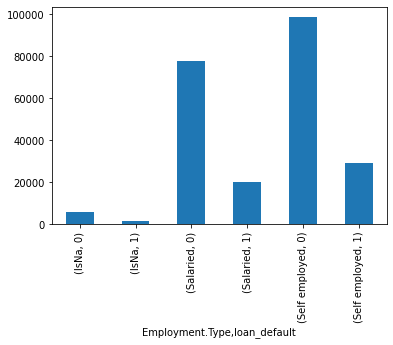

In [11]:
train.fillna('IsNa').groupby(['Employment.Type', 'loan_default'])['UniqueID'].count().plot(kind = 'bar');

## Section III - Prepare Data

In [12]:
#intialize and fit onehotencoder on training data
enc = OneHotEncoder(sparse = False, handle_unknown='ignore').fit(train[['Employment.Type', 'manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION', 'State_ID']].fillna('IsNa'))

In [13]:
#create function for date related features to use on train and test set
def preprocessingfeatures(df):
    '''
    Takes in dataframe and transforms date type features, parse number from existing account age and credit history length columns
    transformed into months only
    Creates new Installment PCT features representing the ratio of installment per total disbursed amount for both primary 
    and secondary loans
    '''
    #get customer age at disbursal
    df['AgeAtDisbursal'] = pd.to_datetime(df['DisbursalDate']).dt.year - pd.to_datetime(df['Date.of.Birth']).apply(lambda x: x.year - 100 if x.year > pd.datetime.now().year else x.year)
    
    #disbursal date info
    df['DisbursalYear'] = pd.to_datetime(df['DisbursalDate']).dt.year
    df['DisbursalMonth'] = pd.to_datetime(df['DisbursalDate']).dt.month
    df['DisbursalWeekday'] = pd.to_datetime(df['DisbursalDate']).dt.weekday
    
    #parse average acct age field info into all months
    df['AVERAGE.ACCT.AGE.MONTHS'] = (df['AVERAGE.ACCT.AGE'].str.split(' ').str[0].str.replace('yrs', '').astype(int) * 12)\
    + (df['AVERAGE.ACCT.AGE'].str.split(' ').str[1].str.replace('mon', '').astype(int))
    
    #parse credit history length field info into all months
    df['CREDIT.HISTORY.LENGTH.MONTHS'] = (df['CREDIT.HISTORY.LENGTH'].str.split(' ').str[0].str.replace('yrs', '').astype(int) * 12)\
    + (df['CREDIT.HISTORY.LENGTH'].str.split(' ').str[1].str.replace('mon', '').astype(int))
    
    #create features of proportion between first installment amount and full loan amount
    df['PRI.Installment.PCT'] = (df['PRIMARY.INSTAL.AMT'] / df['PRI.DISBURSED.AMOUNT']).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['SEC.Installment.PCT'] = (df['SEC.INSTAL.AMT'] / df['SEC.DISBURSED.AMOUNT']).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    
    return df

In [14]:
def onehotencoding(df):
    '''
    Takes in dataframe and transforms specific categorical features with one hot encoder fit on training set
    Outputs dataframe with transformed categorical features, deserived numeric columns and without original categorical
    features
    '''

    #remove unwanted features that either have too many categorical values, will be one hot encoded or are
    #already repensented with another feature
    df_drop = df.drop(['Date.of.Birth', 'CREDIT.HISTORY.LENGTH','DisbursalYear', 'branch_id','DisbursalDate','supplier_id','manufacturer_id','Employee_code_ID','AVERAGE.ACCT.AGE', 'Current_pincode_ID', 'Employment.Type','manufacturer_id','supplier_id', 'PERFORM_CNS.SCORE.DESCRIPTION','State_ID', 'branch_id'], axis=1)
    
    #transform categorical variables of interest with one hot encoder
    df_cat = enc.transform(df[['Employment.Type','manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION','State_ID']].fillna('IsNa'))
    
    #get feature names to include with categorical features
    cols = enc.get_feature_names(['Employment.Type','manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION', 'State_ID'])
    df_cat2 = pd.DataFrame(df_cat)
    df_cat2.columns = cols.tolist()
    
    #create full dataframe with all features of interest to be used in modeling
    df_new = pd.concat([df_drop,df_cat2], axis=1)
    
    return df_new

In [15]:
#create dataframe with onehot endcoded features and target for exploratory data analysis in addition to train df
eda = preprocessingfeatures(train)
eda = onehotencoding(eda).set_index('UniqueID')

**Pearson Correlation Between loan default target and candidate features for predictive model**

In [16]:
pd.DataFrame(eda.corr().sort_values(by = 'loan_default')['loan_default'])

,loan_default
PERFORM_CNS.SCORE,-0.057929
PERFORM_CNS.SCORE.DESCRIPTION_B-Very Low Risk,-0.042176
CREDIT.HISTORY.LENGTH.MONTHS,-0.042126
Aadhar_flag,-0.041593
PRI.ACTIVE.ACCTS,-0.041451
...,...
State_ID_13,0.062586
disbursed_amount,0.077675
ltv,0.098208
loan_default,1.000000


**Visualize**

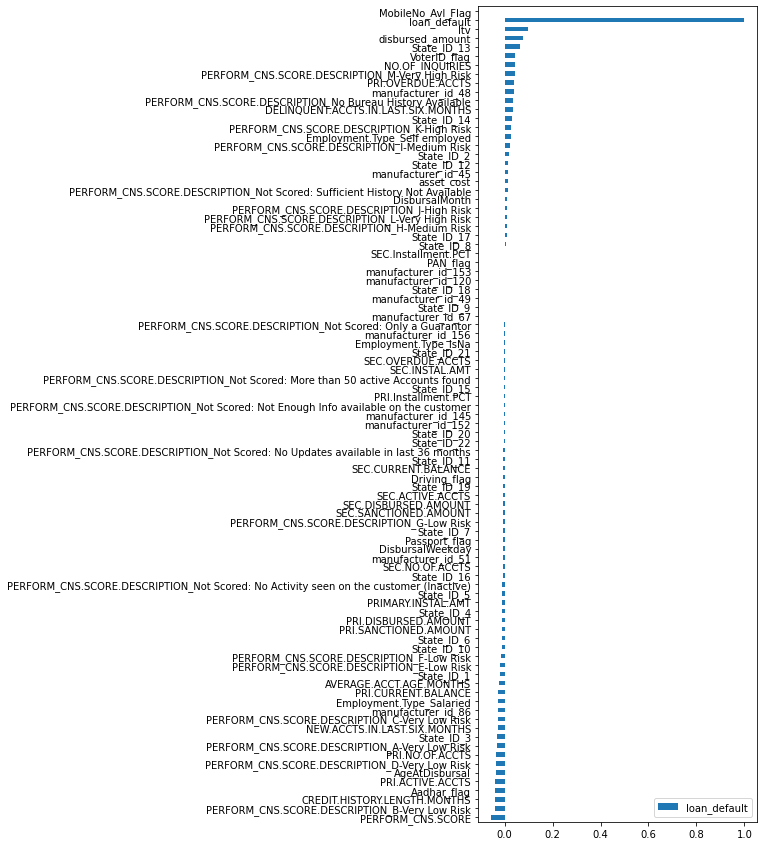

In [17]:
pd.DataFrame(eda.corr().sort_values(by = 'loan_default')['loan_default']).plot(kind = 'barh',figsize=(5,15));

In [18]:
#separate independent variables from dependent variables
X = train[train.columns.difference(['loan_default'])]
y = train['loan_default']

In [19]:
#apply preprocessing functions
X = preprocessingfeatures(X)
X = onehotencoding(X).set_index('UniqueID')

In [20]:
#train test split the training data to use in model assessment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [21]:
X_train.head()

,AVERAGE.ACCT.AGE.MONTHS,Aadhar_flag,AgeAtDisbursal,CREDIT.HISTORY.LENGTH.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,DisbursalMonth,DisbursalWeekday,Driving_flag,MobileNo_Avl_Flag,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,State_ID_13,State_ID_14,State_ID_15,State_ID_16,State_ID_17,State_ID_18,State_ID_19,State_ID_20,State_ID_21,State_ID_22
UniqueID,,,,,,,,,,,,,,,,,,,,,
445041,4,1,35,11,0,8,4,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626473,0,1,36,0,0,10,4,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
528426,0,1,34,0,0,9,5,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
618993,10,1,25,22,0,10,3,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532539,0,1,48,0,0,9,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section IV - Modeling

**Fit Model**

In [22]:
#initialize and split logistic regression
clf = LogisticRegression(random_state=42, max_iter=700).fit(X_train, y_train)

**Validate Model**

In [23]:
#accuracy is misleading here because of class imbalance we saw earlier
clf.score(X_test, y_test)

0.782848319787266

In [24]:
#confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test,clf.predict(X_test)).ravel()
tn, fp, fn, tp

(36505, 4, 10122, 0)

In [25]:
metrics.f1_score(y_test, clf.predict(X_test), average='binary')

0.0

In [26]:
metrics.roc_auc_score(y_test, clf.predict(X_test))

0.4999452189870991

**Checking to see if adjusting the threshold would improve performance**

In [27]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,(clf.predict_proba(X_test)[:,1]>=0.25).astype(int)).ravel()
tn, fp, fn, tp

(20879, 15630, 5167, 4955)

In [28]:
metrics.f1_score(y_test, (clf.predict_proba(X_test)[:,1]>=0.25).astype(int), average='binary')

0.3227277168072426

In [29]:
metrics.roc_auc_score(y_test, (clf.predict_proba(X_test)[:,1]>=0.25).astype(int))

0.5307070727456186

# Section V - Evaluate Results

## 1) What are the most influential attributes associated with vehicle loan defaults?

In [30]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = clf.coef_.T.tolist()
coefs_df = coefs_df.explode('coefs')
coefs_df['abs_coefs'] = np.abs(coefs_df['coefs'])
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df

,est_int,coefs,abs_coefs
31,asset_cost,-2.7014e-05,2.7014e-05
32,disbursed_amount,1.54176e-05,1.54176e-05
12,PERFORM_CNS.SCORE,-1.57586e-06,1.57586e-06
29,SEC.SANCTIONED.AMOUNT,-6.34273e-07,6.34273e-07
15,PRI.DISBURSED.AMOUNT,5.73782e-07,5.73782e-07
...,...,...,...
28,SEC.OVERDUE.ACCTS,3.94236e-12,3.94236e-12
46,manufacturer_id_153,1.22295e-12,1.22295e-12
45,manufacturer_id_152,-8.41035e-15,8.41035e-15
62,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More...,-4.61261e-15,4.61261e-15


## Visualize 

### Top 5 coefficients by absolute value used in logistic regression model

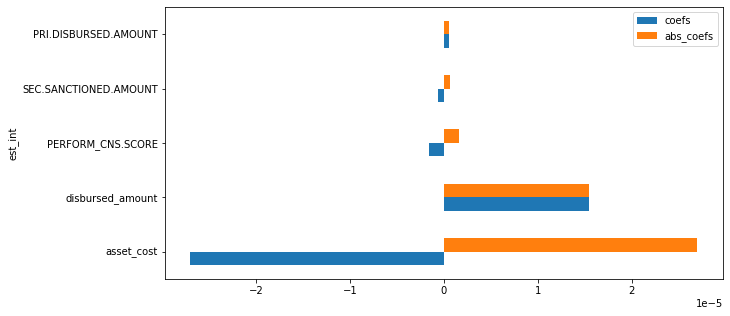

In [31]:
coefs_df.set_index('est_int').sort_values('abs_coefs', ascending=False).head(5).plot(kind = 'barh',figsize=(10,5));

## The most influential features relative to vehicle loan defaulting in this analysis so far are asset_cost, disbursed_amount, PERFORM_CNS.SCORE, SEC.SANTIONED_AMOUNT, and PRI.DISBURSED.AMOUNT

### A little deeper look into the top 5 features and relationship with loan default

In [32]:
eda.groupby(['loan_default'])[['disbursed_amount', 'asset_cost']].describe()

disbursed_amount                                                \
                        count          mean           std      min      25%   
loan_default                                                                  
0                    182543.0  53826.471111  13140.699007  13320.0  46369.0   
1                     50611.0  56270.473869  12150.255527  13369.0  49303.0   

                                         asset_cost                \
                  50%      75%       max      count          mean   
loan_default                                                        
0             53303.0  59947.0  990572.0   182543.0  75722.806128   
1             55459.0  61947.0  191392.0    50611.0  76378.176661   

                                                                           
                       std      min      25%      50%      75%        max  
loan_default                                                               
0             19015.002867  37000.0  65680.0  70845.0  78999.0  1628992.0  
1             18680.502609  37000.0  65894.0  71326.0  80061.5   281164.0

**Slightly higher mean of disbursed_amount and asset_cost for defaulted cases**

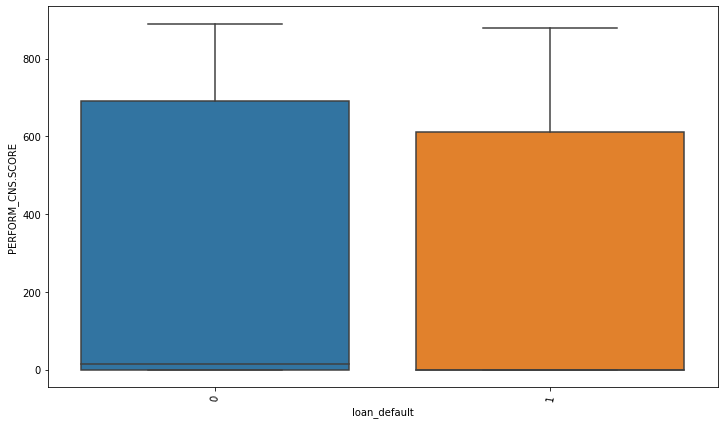

In [33]:
plt.figure(figsize=(12,7))
sn.boxplot(x='loan_default', y="PERFORM_CNS.SCORE", data=train)
plt.xticks(rotation=80);

In [34]:
eda.groupby(['loan_default'])['PERFORM_CNS.SCORE'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,299.784270,342.883794,0.0,0.0,15.0,690.0,890.0
1,50611.0,252.236372,318.826242,0.0,0.0,0.0,610.0,879.0


**Non defaulted loanees have higher average score than those that did**

## 2) If someone has been shopping around for loans, what is the relationship between number of loan inquiries and potential to default the loan?

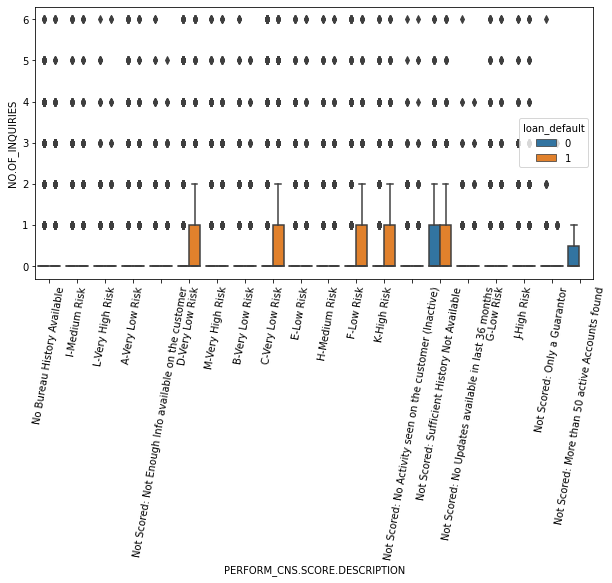

In [35]:
plt.figure(figsize=(10,5))
sn.boxplot(x='PERFORM_CNS.SCORE.DESCRIPTION', y="NO.OF_INQUIRIES",hue="loan_default", data=train.query("`NO.OF_INQUIRIES` <= 6"))
plt.xticks(rotation=80);

In [36]:
train.groupby(['loan_default'])['NO.OF_INQUIRIES'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,0.190366,0.665536,0.0,0.0,0.0,0.0,36.0
1,50611.0,0.265219,0.835147,0.0,0.0,0.0,0.0,19.0


## It seems those with lower bureau scores (that have been scored) and defaulted their loans, do tend to have more inquiries.

## 3) How does credit history age affect risk to default?

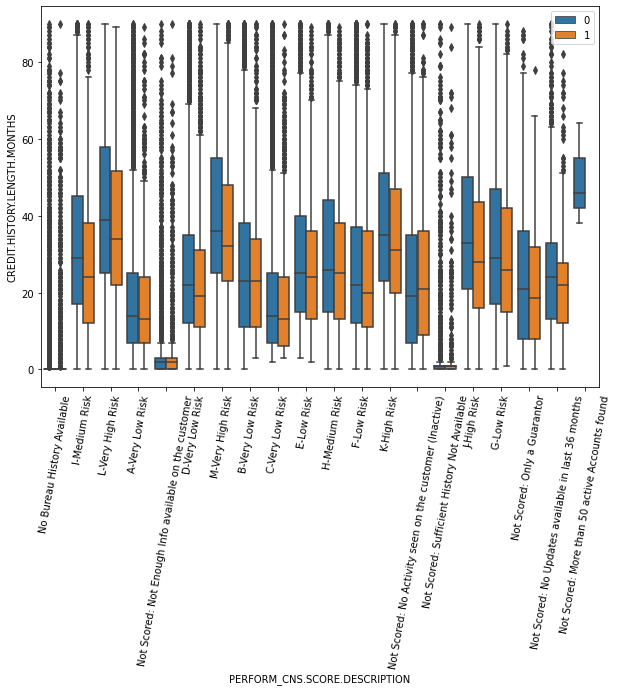

In [37]:
plt.figure(figsize=(10,7))
sn.boxplot(x='PERFORM_CNS.SCORE.DESCRIPTION', y="CREDIT.HISTORY.LENGTH.MONTHS",hue='loan_default',data=train.query('`CREDIT.HISTORY.LENGTH.MONTHS`<=90'))
plt.legend(loc='upper right')
plt.xticks(rotation=80);

## Loanees with high, very high, medium and no bureau history available with longer credit history are slightly less likely to default their loans based on my analysis so far

In [38]:
eda.groupby(['loan_default'])['CREDIT.HISTORY.LENGTH.MONTHS'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,16.886377,29.342245,0.0,0.0,0.0,24.0,449.0
1,50611.0,13.965798,25.519395,0.0,0.0,0.0,21.0,468.0


**Loanees without default have slightly higher average of credit history length than those who did**

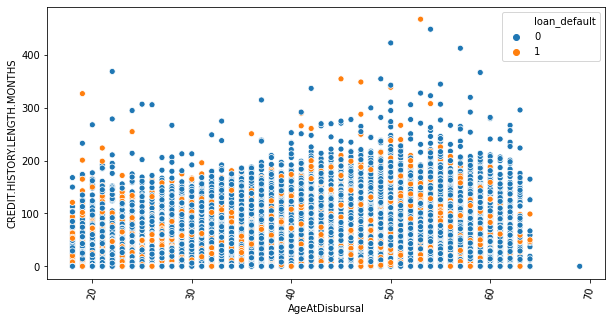

In [39]:
plt.figure(figsize=(10,5))
sn.scatterplot(x='AgeAtDisbursal', y="CREDIT.HISTORY.LENGTH.MONTHS",hue="loan_default", data=train)
plt.xticks(rotation=80);

**There doesn't seem to be a direct pattern with age of loanee at time of disbursal, CREDIT.HISTORY.LENGTH.MONTHS and loan_default**

# Section VI - Apply Model on Unlabeled Data

In [40]:
X1 = test[test.columns.difference(['loan_default'])]
X1 = preprocessingfeatures(X1)

In [41]:
X1 = onehotencoding(X1).set_index('UniqueID')

In [42]:
y_hats = (clf.predict_proba(X1)[:,1]>=0.3).astype(int)
y_probs = clf.predict_proba(X1)

In [43]:
X1['prediction'] = y_hats
X1['predictionprob_true'] = y_probs[:,0]
X1['predictionprob_false'] = y_probs[:,1]

Count how many were predicted to default in new data

In [44]:
X1.prediction.value_counts()

1    112381
0        11
Name: prediction, dtype: int64

In [45]:
X1.head()

,Aadhar_flag,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Driving_flag,MobileNo_Avl_Flag,NEW.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,PAN_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.CURRENT.BALANCE,...,State_ID_16,State_ID_17,State_ID_18,State_ID_19,State_ID_20,State_ID_21,State_ID_22,prediction,predictionprob_true,predictionprob_false
UniqueID,,,,,,,,,,,,,,,,,,,,,
655269,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.495982,0.504018
723482,1,0,0,1,1,1,0,749,1,43898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.496575,0.503425
758529,1,0,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.494305,0.505695
763449,1,0,0,1,0,0,0,14,1,132480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.495945,0.504055
708663,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.495811,0.504189
